# Exploritory Data Analysis

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import StratifiedKFold
import pickle

In [ ]:
raw_data = pd.read_csv("predictive_maintenance_raw_data.csv", index_col = 0)
raw_data

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [ ]:
failure_types = raw_data['Failure Type'].value_counts()
failure_types

20631
13096


In [ ]:
raw_data.hist(column=["Air temperature [K]", "Process temperature [K]", "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]"], bins=50, figsize=(20,8))

,0
0,112
1,98
2,69
3,82
4,91


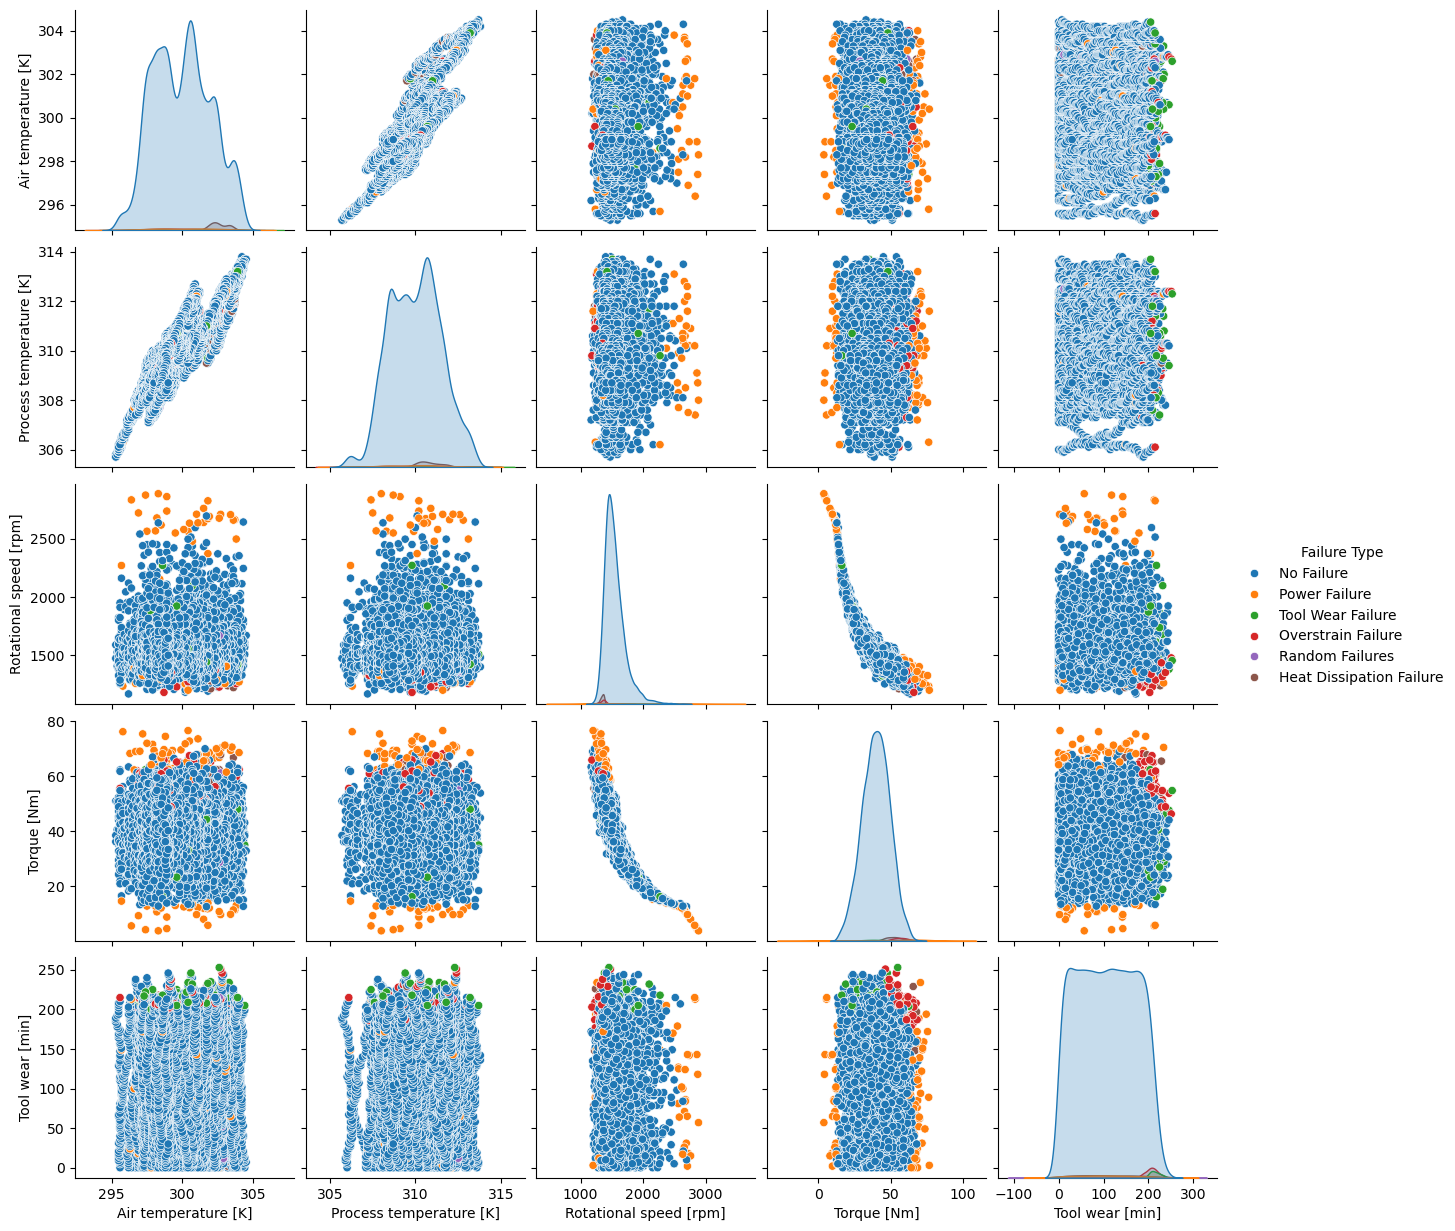

In [6]:
sns.pairplot(raw_data.drop('Target', axis=1), hue = "Failure Type", dropna=True, diag_kind='kde')

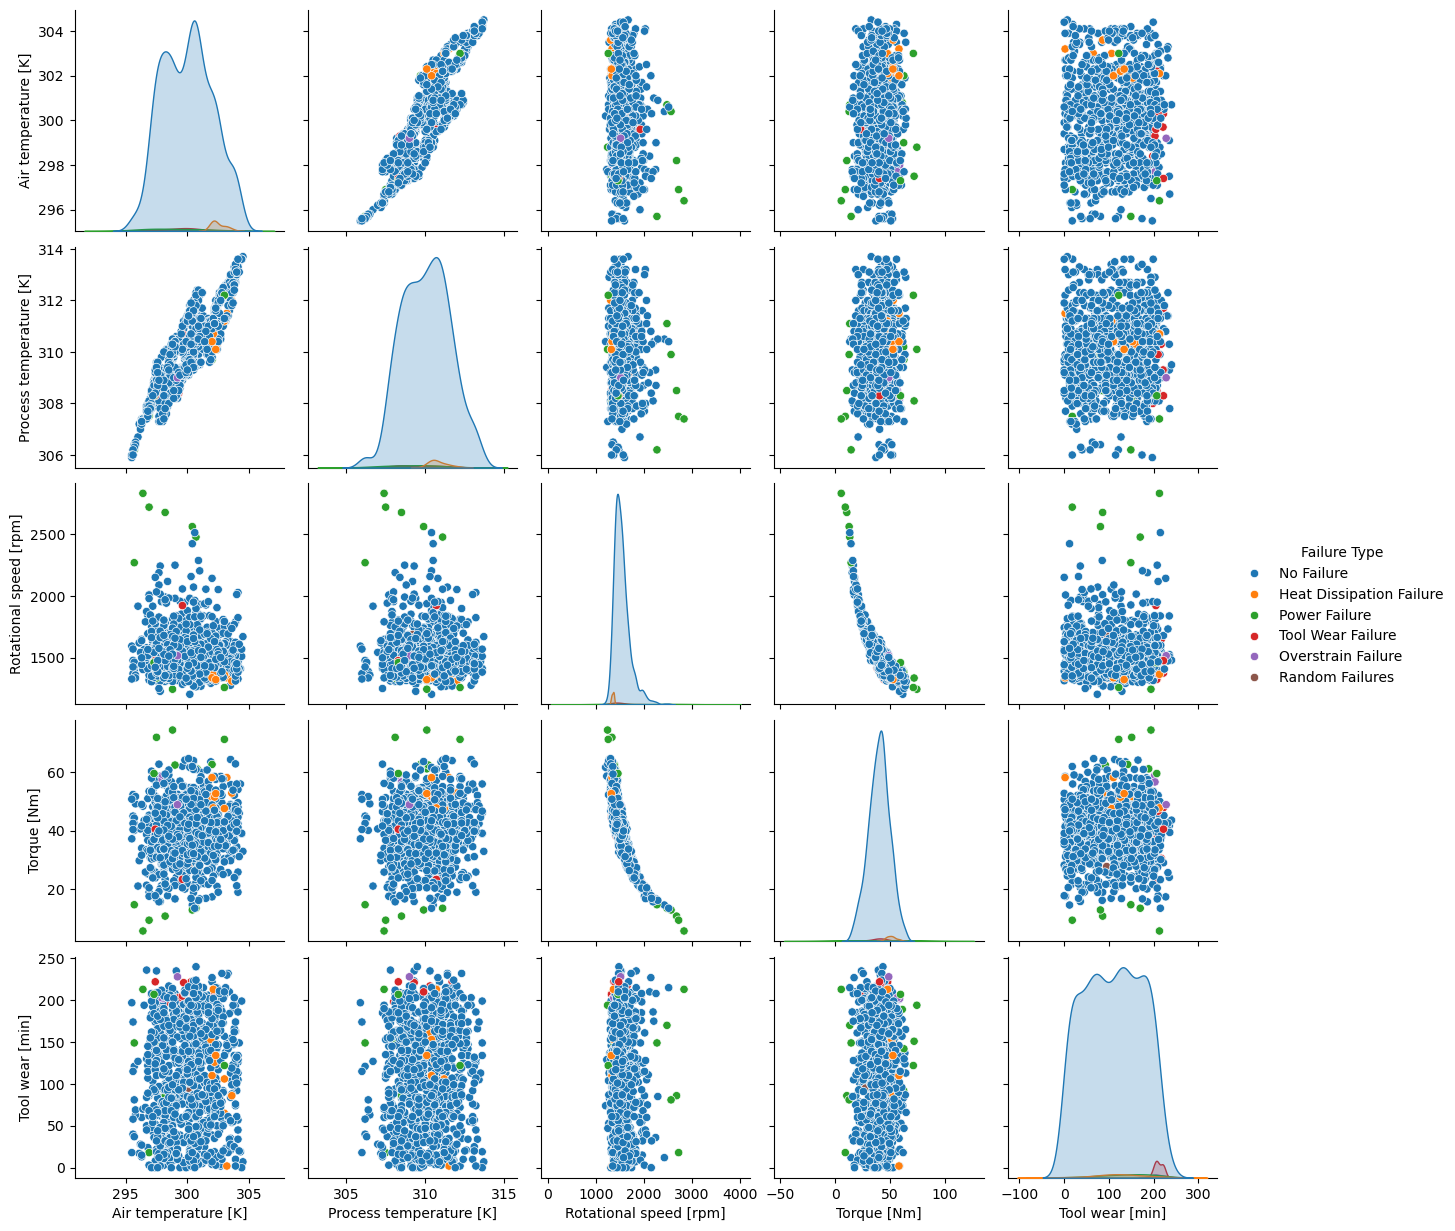

In [7]:
sns.pairplot(raw_data.drop('Target', axis=1).sample(n=1000, random_state=349), hue = "Failure Type", dropna=True, diag_kind='kde')

Based on these findings, we can identify torque and rotational speed as some key features based on the density plots and relations between other features. Note, if using a model which assumes no multicollinearity we would plot a heatmap and potentially remove one of torque or rotational speed, and one of the temperature variables. 

# Preprocessing & Feature Scaling

array([[<Axes: title={'center': 'Log Tool wear [min]'}>]], dtype=object)

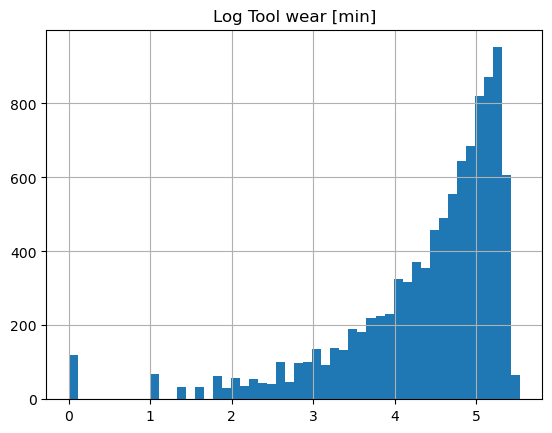

In [8]:
raw_data['Log Tool wear [min]'] = np.log1p(raw_data['Tool wear [min]'])
raw_data.hist(column=["Log Tool wear [min]"], bins = 50)

We can see that this scale is much more gaussian which is beneficial for gaussian anomaly detection and helps with stabalized LTSM networks. 

In [9]:
#reload so we can apply all transformations and save
raw_data = pd.read_csv("predictive_maintenance_raw_data.csv", index_col = 0)
raw_data

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
UDI,,,,,,,,,
1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...,...
9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure


In [16]:
log_features = ['Tool wear [min]', 'Rotational speed [rpm]']
scale_features = ['Torque [Nm]', 'Process temperature [K]', 'Air temperature [K]']

log_transformer = Pipeline([ ('log1p', FunctionTransformer(np.log1p, validate=True)), ('scaler', StandardScaler()) ])

scale_transformer = Pipeline([ ('scaler', StandardScaler()) ])

preprocessor = ColumnTransformer(transformers=[ ('log', log_transformer, log_features), ('scale', scale_transformer, scale_features) ])

X_processed = preprocessor.fit_transform(raw_data[log_features + scale_features])

with open('preprocessing_pipeline.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)


In [22]:
scaled_data = pd.DataFrame(X_processed, columns = ['Tool wear [min]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Process temperature [K]', 'Air temperature [K]'], index = raw_data.index)

In [18]:
scaled_data

,Tool wear [min],Rotational speed [rpm],Torque [Nm],Process temperature [K],Air temperature [K]
UDI,,,,,
1,-4.356265,0.130021,0.282200,-0.947360,-0.952389
2,-2.976554,-0.769653,0.633308,-0.879959,-0.902393
3,-2.573014,-0.193370,0.944290,-1.014761,-0.952389
4,-2.286698,-0.605963,-0.048845,-0.947360,-0.902393
5,-2.064614,-0.769653,0.001313,-0.879959,-0.902393
...,...,...,...,...,...
9996,-1.661074,0.442551,-1.052012,-1.082162,-0.602417
9997,-1.479618,0.603519,-0.821283,-1.082162,-0.552421
9998,-1.235660,0.677319,-0.660777,-0.947360,-0.502425


Now that we've validated our feature scaling and saved the pipeline we will create a training, testing, cross validation split. Recall, that we counted the number of failure samples for each time in the data set and we have about 400 failures with about 50 - 100 in each class. This is enough to create all three sets. 